# CS498PS - Lab 2: Filter Design and Usage

For this lab you will learn how to design some simple filters and how to apply them to solve some common audio problems. Python’s scipy.signal package has an extensive set of commands to help you design filters (firwin, firwin2, butter, cheby1, cheby2,  ellip, …), so there is no shortage of options.

## Part 1: When to use what 

There will be four cases to this part, each requiring a different type of filter to address a problem in a recording.  The input recordings are:

- ```case1.wav``` [https://drive.google.com/uc?export=download&id=1eTsDiXqqLQv3murPz25O54E89i3DL__d ] : A noise-corrupted speech signal. We want to eliminate the noise.
- ```case2.wav``` [https://drive.google.com/uc?export=download&id=1egd22CxPUe6sINIi0FPTbMfG4S_In2hT ] : Same as above, different type of noise. We want to remove the noise again.
- ```case3.wav``` [https://drive.google.com/uc?export=download&id=1eF-VOVWoT1rh1wAC06WT1ANusMKyDYSn ] : Bird songs during a thunderstorm. As a world renowned ornithologist you need to have a cleaner recording of the bird songs for further analysis.
- ```case4.wav``` [https://drive.google.com/uc?export=download&id=1eeizGhrBICf6pW5OXcbq7ChF4m2N6yIk ]: The signal that we require to extract here is a Morse code which is buried in environmental noise. Design a filter to bring out the beeps.

For each case do the following:
- Plot the spectrogram of the given sound and identify the problem
- Describe what kind of filter will address this problem and why
- Design an FIR filter using ```scipy.signal.firwin()``` and/or ```scipy.signal.firwin2()```
- Design an FIR filter using the formulas in my slides (i.e. do not use ```scipy.signal```)
- Design an IIR Butterworth filter using ```scipy.signal```'s routines
- Show a plot comparing the response of all the filters (hint: ```scipy.signal.freqz```)
- Plot spectrograms of the filtered recordings and compare with the input to show that it fixed the problem
- Play the filtered sounds so that we can hear how well it works

Make some observations on how the results differ between an FIR and IIR filter and try to find the best possible filter size/type/parameters to produce the best result. Show results under various parameters (e.g. filter length) and make some plots that demonstrate the effects of these parameters. Most importantly, try to get a sense of how these design choices impact audible quality. Being able to listen at a sound and identify what’s wrong and how to fix it is a big part of audio processing.

Hint: To apply an FIR filter you can use ```scipy.signal.convolve```, to apply an IIR filter (or an FIR) you can use ```scipy,signal.lfilter```.


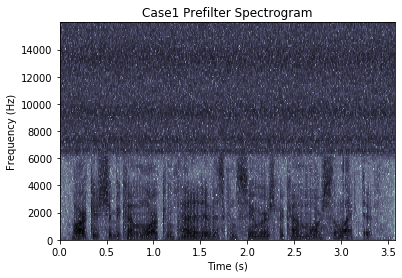

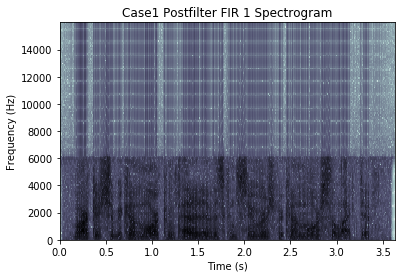

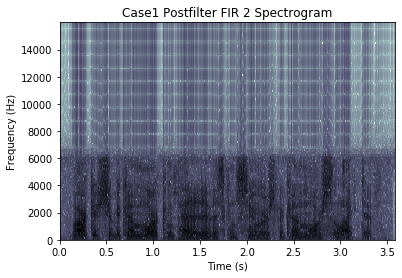

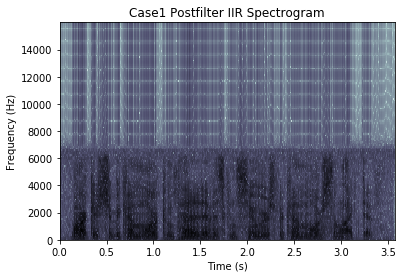

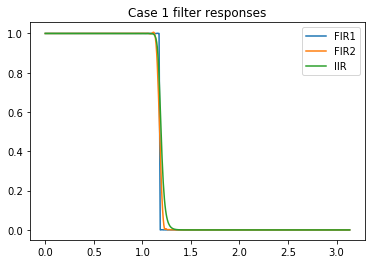

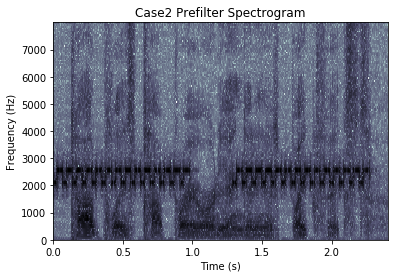

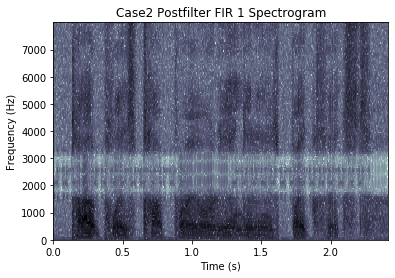

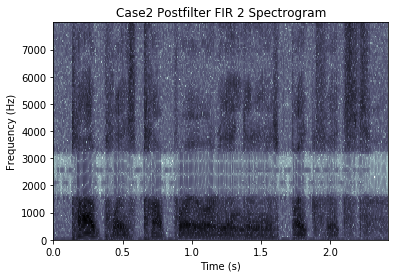

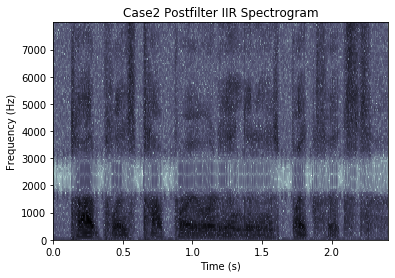

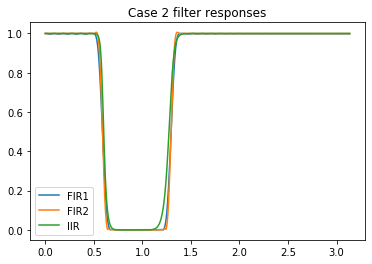

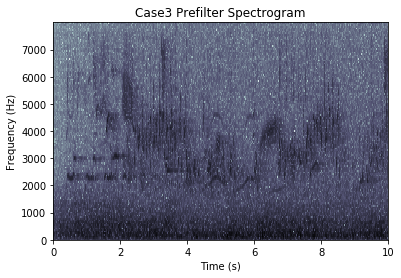

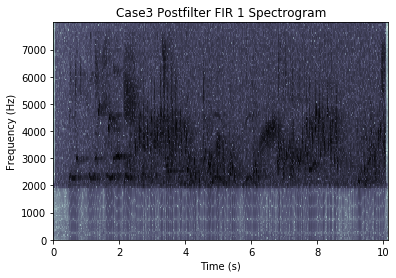

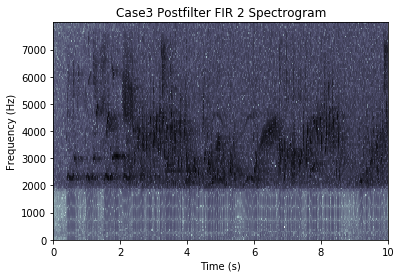

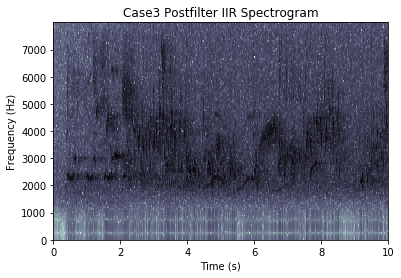

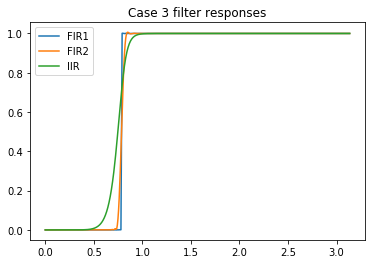

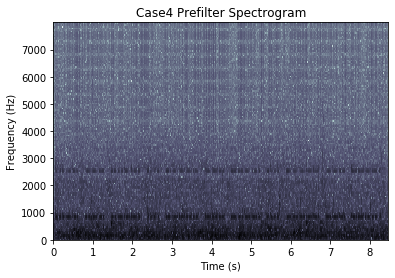

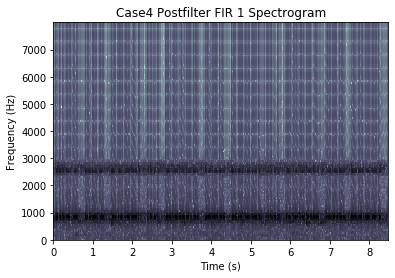

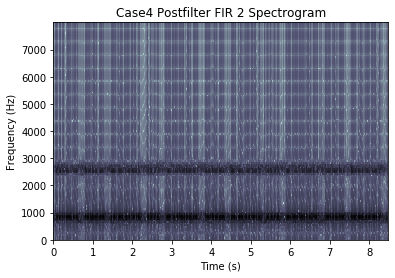

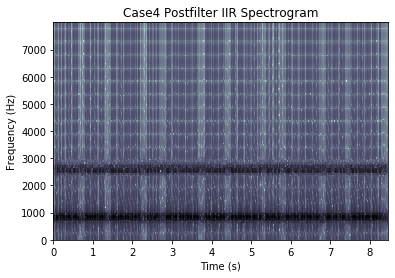

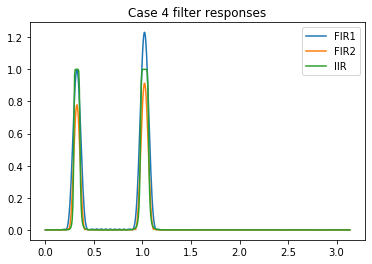

In [25]:
import numpy as np
import scipy.io.wavfile
import scipy.signal
import scipy
import math
import matplotlib.pyplot as plt

# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    # YOUR CODE HERE
    input_size = np.shape(input_sound)[0]
    zeros_to_append = dft_size - (input_size % dft_size)
    even_input = np.append(input_sound, np.zeros(zeros_to_append))

    frames = []
    frame_idx = dft_size
    while(frame_idx <= len(input_sound)):
        frame = even_input[(frame_idx-dft_size):frame_idx]
        frame = np.append(frame, np.zeros(zero_pad))
        frame *= window
        frames.append(frame)
        frame_idx += hop_size
        
    dfts = np.fft.rfft(frames[0])
    for i in range(1, len(frames)):
        dfts = np.vstack((dfts, np.fft.rfft(frames[i])))

    # Return a complex-valued spectrogram (frequencies x time)
    return dfts

def plot_spec(input_sound, input_sr, stft_out, dft_size, zero_pad, audio_type):
    time_range = np.linspace(0, float(len(input_sound))/float(input_sr), len(stft_out))
    max_freq = np.max(np.fft.fftfreq(input_sound.size, 1.0/input_sr))
    freq_range = (np.linspace(0, max_freq, num=int(((dft_size+zero_pad)/2+1))))
    stft_out = np.abs(np.transpose(stft_out[:-1,:-1].real))**0.5    
    if audio_type == 'Case1 Prefilter':
        plt.figure(1)
    elif audio_type == 'Case1 Postfilter FIR 1':
        plt.figure(2)
    elif audio_type == 'Case1 Postfilter FIR 2':
        plt.figure(3)
    elif audio_type == 'Case1 Postfilter IIR':
        plt.figure(4)
    elif audio_type == 'Case2 Prefilter':
        plt.figure(6)
    elif audio_type == 'Case2 Postfilter FIR 1':
        plt.figure(7)
    elif audio_type == 'Case2 Postfilter FIR 2':
        plt.figure(8)
    elif audio_type == 'Case2 Postfilter IIR':
        plt.figure(9)
    elif audio_type == 'Case3 Prefilter':
        plt.figure(11)
    elif audio_type == 'Case3 Postfilter FIR 1':
        plt.figure(12)
    elif audio_type == 'Case3 Postfilter FIR 2':
        plt.figure(13)
    elif audio_type == 'Case3 Postfilter IIR':
        plt.figure(14)
    elif audio_type == 'Case4 Prefilter':
        plt.figure(16)
    elif audio_type == 'Case4 Postfilter FIR 1':
        plt.figure(17)
    elif audio_type == 'Case4 Postfilter FIR 2':
        plt.figure(18)
    elif audio_type == 'Case4 Postfilter IIR':
        plt.figure(19)
    elif audio_type == 'Case1 Equalizer':
        plt.figure(20)
    elif audio_type == 'Case2 Equalizer':
        plt.figure(21)
    elif audio_type == 'Case3 Equalizer':
        plt.figure(22)
    elif audio_type == 'Case4 Equalizer':
        plt.figure(23)
    plt.pcolormesh(time_range, freq_range, np.log10(stft_out)*10, cmap='bone_r')
    plt.title(audio_type + ' Spectrogram')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")

# Load the sound, play it, and plot it's spectrogram
# YOUR CODE HERE
dft_size = 256
hop_size = 64
zero_pad = 16
window = np.hanning(dft_size + zero_pad)


#Case 1: Use lowpass filter to filter out the high frequency noise
case1_sr, case1_audio = scipy.io.wavfile.read('data/Lab2/case1.wav')
sound(case1_audio, rate=case1_sr, label='case1 prefilter')
case1_stft = stft(case1_audio, dft_size, hop_size, zero_pad, window)
plot_spec(case1_audio, case1_sr, case1_stft, dft_size, zero_pad, 'Case1 Prefilter')

# Design a filter that fixes things
# YOUR CODE HERE
case1_fir_filter1 = scipy.signal.firwin(numtaps=len(case1_stft), cutoff=6000, pass_zero='lowpass', fs=case1_sr)
case1_filtered1 = scipy.signal.convolve(case1_fir_filter1, case1_audio)

case1_fir_filter2 = 6000/case1_sr*2*np.sinc(2*6000/case1_sr*np.arange(-100,100))*np.hanning(200)
case1_filtered2 = scipy.signal.convolve(case1_fir_filter2, case1_audio)

case1_iir_filter = scipy.signal.iirfilter(N=35, Wn=[6000/(case1_sr/2)], btype='lowpass', ftype='butter')
case1_filtered3 = scipy.signal.lfilter(case1_iir_filter[0], case1_iir_filter[1], case1_audio)

# Show me the resulting spectrogram and sound
# YOUR CODE HERE
case1_filtered1_stft = stft(case1_filtered1, dft_size, hop_size, zero_pad, window)
plot_spec(case1_filtered1, case1_sr, case1_filtered1_stft, dft_size, zero_pad, 'Case1 Postfilter FIR 1')
sound(case1_filtered1, rate=case1_sr, label='case1 postfilter FIR1')

case1_filtered2_stft = stft(case1_filtered2, dft_size, hop_size, zero_pad, window)
plot_spec(case1_filtered2, case1_sr, case1_filtered2_stft, dft_size, zero_pad, 'Case1 Postfilter FIR 2')
sound(case1_filtered2, rate=case1_sr, label='case1 postfilter FIR2')

case1_filtered3_stft = stft(case1_filtered3, dft_size, hop_size, zero_pad, window)
plot_spec(case1_filtered3, case1_sr, case1_filtered3_stft, dft_size, zero_pad, 'Case1 Postfilter IIR')
sound(case1_filtered3, rate=case1_sr, label='case1 postfilter IIR')

case1_w1, case1_h1 = scipy.signal.freqz(case1_fir_filter1)
case1_w2, case1_h2 = scipy.signal.freqz(case1_fir_filter2)
case1_w3, case1_h3 = scipy.signal.freqz(case1_iir_filter[0], case1_iir_filter[1])
plt.figure(5)
plt.title("Case 1 filter responses")
plt.plot(case1_w1, np.abs(case1_h1), label='FIR1')
plt.plot(case1_w2, np.abs(case1_h2), label='FIR2')
plt.plot(case1_w3, np.abs(case1_h3), label='IIR')
plt.legend()

# Repeat for cases 2, 3, and 4
# YOUR CODE HERE


#Case 2: Use bandstop filter to filter out the specific frequencies of the noise
case2_sr, case2_audio = scipy.io.wavfile.read('data/Lab2/case2.wav')
sound(case2_audio, rate=case2_sr, label='case2 prefilter')
case2_stft = stft(case2_audio, dft_size, hop_size, zero_pad, window)
plot_spec(case2_audio, case2_sr, case2_stft, dft_size, zero_pad, 'Case2 Prefilter')

case2_fir_filter1 = scipy.signal.firwin(numtaps=len(case2_stft[0]), cutoff=[1500,3300], pass_zero='bandstop',fs=case2_sr)
case2_filtered1 = scipy.signal.convolve(case2_fir_filter1, case2_audio)
case2_filtered1_stft = stft(case2_filtered1, dft_size, hop_size, zero_pad, window)
plot_spec(case2_filtered1, case2_sr, case2_filtered1_stft, dft_size, zero_pad, 'Case2 Postfilter FIR 1')
sound(case2_filtered1, rate=case2_sr, label='case2 postfilter FIR1')

case2_fir_filter2_1 = 1500/case2_sr*2*np.sinc(2*1500/case2_sr*np.arange(-100,100))*np.hanning(200)
case2_fir_filter2_2 = -3300/case2_sr*2*np.sinc(2*3300/case2_sr*np.arange(-100,100))*np.hanning(200)
case2_fir_filter2_2[100]+=1
case2_fir_filter2 = case2_fir_filter2_1 + case2_fir_filter2_2
case2_filtered2 = scipy.signal.convolve(case2_fir_filter2, case2_audio)
case2_filtered2_stft = stft(case2_filtered2, dft_size, hop_size, zero_pad, window)
plot_spec(case2_filtered2, case2_sr, case2_filtered2_stft, dft_size, zero_pad, 'Case2 Postfilter FIR 2')
sound(case2_filtered2, rate=case2_sr, label='case2 postfilter FIR2')

case2_iir_filter = scipy.signal.iirfilter(N=10, Wn=[1500/(case2_sr/2),3300/(case2_sr/2)], btype='bandstop', ftype='butter')
case2_filtered3 = scipy.signal.lfilter(case2_iir_filter[0], case2_iir_filter[1], case2_audio)
case2_filtered3_stft = stft(case2_filtered3, dft_size, hop_size, zero_pad, window)
plot_spec(case2_filtered3, case2_sr, case2_filtered3_stft, dft_size, zero_pad, 'Case2 Postfilter IIR')
sound(case2_filtered3, rate=case2_sr, label='case2 postfilter IIR')

case2_w1, case2_h1 = scipy.signal.freqz(case2_fir_filter1)
case2_w2, case2_h2 = scipy.signal.freqz(case2_fir_filter2)
case2_w3, case2_h3 = scipy.signal.freqz(case2_iir_filter[0], case2_iir_filter[1])
plt.figure(10)
plt.title("Case 2 filter responses")
plt.plot(case2_w1, np.abs(case2_h1), label='FIR1')
plt.plot(case2_w2, np.abs(case2_h2), label='FIR2')
plt.plot(case2_w3, np.abs(case2_h3), label='IIR')
plt.legend()


#Case 3: Use highpass filter to filter out the low frequency noise
case3_sr, case3_audio = scipy.io.wavfile.read('data/Lab2/case3.wav')
sound(case3_audio, rate=case3_sr, label='case3 prefilter')
case3_stft = stft(case3_audio, dft_size, hop_size, zero_pad, window)
plot_spec(case3_audio, case3_sr, case3_stft, dft_size, zero_pad, 'Case3 Prefilter')

case3_fir_filter1 = scipy.signal.firwin(numtaps=len(case3_stft), cutoff=[2000], pass_zero='highpass',fs=case3_sr)
case3_filtered1 = scipy.signal.convolve(case3_fir_filter1, case3_audio)
case3_filtered1_stft = stft(case3_filtered1, dft_size, hop_size, zero_pad, window)
plot_spec(case3_filtered1, case3_sr, case3_filtered1_stft, dft_size, zero_pad, 'Case3 Postfilter FIR 1')
sound(case3_filtered1, rate=case3_sr, label='case3 postfilter FIR1')

case3_fir_filter2 = -2000/case3_sr*2*np.sinc(2*2000/case3_sr*np.arange(-100,100))*np.hanning(200)
case3_fir_filter2[100]+=1
case3_filtered2 = scipy.signal.convolve(case3_fir_filter2, case3_audio)
case3_filtered2_stft = stft(case3_filtered2, dft_size, hop_size, zero_pad, window)
plot_spec(case3_filtered2, case3_sr, case3_filtered2_stft, dft_size, zero_pad, 'Case3 Postfilter FIR 2')
sound(case3_filtered2, rate=case3_sr, label='case3 postfilter FIR2')

case3_iir_filter = scipy.signal.iirfilter(N=10, Wn=[2000/(case3_sr/2)], btype='highpass', ftype='butter')
case3_filtered3 = scipy.signal.lfilter(case3_iir_filter[0], case3_iir_filter[1], case3_audio)
case3_filtered3_stft = stft(case3_filtered3, dft_size, hop_size, zero_pad, window)
plot_spec(case3_filtered3, case3_sr, case3_filtered3_stft, dft_size, zero_pad, 'Case3 Postfilter IIR')
sound(case3_filtered3, rate=case3_sr, label='case3 postfilter IIR')

case3_w1, case3_h1 = scipy.signal.freqz(case3_fir_filter1)
case3_w2, case3_h2 = scipy.signal.freqz(case3_fir_filter2)
case3_w3, case3_h3 = scipy.signal.freqz(case3_iir_filter[0], case3_iir_filter[1])
plt.figure(15)
plt.title("Case 3 filter responses")
plt.plot(case3_w1, np.abs(case3_h1), label='FIR1')
plt.plot(case3_w2, np.abs(case3_h2), label='FIR2')
plt.plot(case3_w3, np.abs(case3_h3), label='IIR')
plt.legend()


#Case 4: Use bandpass filter to pass in the morse code frequencies
case4_sr, case4_audio = scipy.io.wavfile.read('data/Lab2/case4.wav')
sound(case4_audio, rate=case4_sr, label='case4 prefilter')
case4_stft = stft(case4_audio, dft_size, hop_size, zero_pad, window)
plot_spec(case4_audio, case4_sr, case4_stft, dft_size, zero_pad, 'Case4 Prefilter')

case4_fir_filter1 = scipy.signal.firwin(numtaps=len(case4_stft[0]), cutoff=[750,900,2500,2700], pass_zero='bandpass',fs=case4_sr)
case4_filtered1 = scipy.signal.convolve(case4_fir_filter1, case4_audio)
case4_filtered1_stft = stft(case4_filtered1, dft_size, hop_size, zero_pad, window)
plot_spec(case4_filtered1, case4_sr, case4_filtered1_stft, dft_size, zero_pad, 'Case4 Postfilter FIR 1')
sound(case4_filtered1, rate=case4_sr, label='case4 postfilter FIR1')

case4_fir_filter2_low1 = 750/case4_sr*2*np.sinc(2*750/case4_sr*np.arange(-100,100))*np.hanning(200)
case4_fir_filter2_high1 = -900/case4_sr*2*np.sinc(2*900/case4_sr*np.arange(-100,100))*np.hanning(200)
case4_fir_filter2_high1[100]+=1
case4_fir_filter2_low2 = 2500/case4_sr*2*np.sinc(2*2500/case4_sr*np.arange(-100,100))*np.hanning(200)
case4_fir_filter2_high2 = -2700/case4_sr*2*np.sinc(2*2700/case4_sr*np.arange(-100,100))*np.hanning(200)
case4_fir_filter2_high2[100]+=1
case4_fir_filter2_1 = -(case4_fir_filter2_low1 + case4_fir_filter2_high1)
case4_fir_filter2_1[100]+=1
case4_fir_filter2_2 = -(case4_fir_filter2_low2 + case4_fir_filter2_high2)
case4_fir_filter2_2[100]+=1
case4_fir_filter2 = case4_fir_filter2_1 + case4_fir_filter2_2
case4_filtered2 = scipy.signal.convolve(case4_fir_filter2, case4_audio)
case4_filtered2_stft = stft(case4_filtered2, dft_size, hop_size, zero_pad, window)
plot_spec(case4_filtered2, case4_sr, case4_filtered2_stft, dft_size, zero_pad, 'Case4 Postfilter FIR 2')
sound(case4_filtered2, rate=case4_sr, label='case4 postfilter FIR2')

case4_iir_filter_1 = scipy.signal.iirfilter(N=5, Wn=[750/(case4_sr/2),900/(case4_sr/2)], btype='bandpass', ftype='butter')
case4_iir_filter_2 = scipy.signal.iirfilter(N=5, Wn=[2500/(case4_sr/2),2700/(case4_sr/2)], btype='bandpass', ftype='butter')
case4_filtered3_1 = scipy.signal.lfilter(case4_iir_filter_1[0], case4_iir_filter_1[1], case4_audio)
case4_filtered3_2 = scipy.signal.lfilter(case4_iir_filter_2[0], case4_iir_filter_2[1], case4_audio)
case4_filtered3 = case4_filtered3_1 + case4_filtered3_2
case4_filtered3_stft = stft(case4_filtered3, dft_size, hop_size, zero_pad, window)
plot_spec(case4_filtered3, case4_sr, case4_filtered3_stft, dft_size, zero_pad, 'Case4 Postfilter IIR')
sound(case4_filtered3, rate=case4_sr, label='case4 postfilter IIR')

case4_w1, case4_h1 = scipy.signal.freqz(case4_fir_filter1)
case4_w2, case4_h2 = scipy.signal.freqz(case4_fir_filter2)
case4_w3_1, case4_h3_1 = scipy.signal.freqz(case4_iir_filter_1[0], case4_iir_filter_1[1])
case4_w3_2, case4_h3_2 = scipy.signal.freqz(case4_iir_filter_2[0], case4_iir_filter_2[1])
case4_w3 = np.append(case4_w3_1[:100], case4_w3_2[100:])
case4_h3 = np.append(case4_h3_1[:100], case4_h3_2[100:])
plt.figure(20)
plt.title("Case 4 filter responses")
plt.plot(case4_w1, np.abs(case4_h1), label='FIR1')
plt.plot(case4_w2, np.abs(case4_h2), label='FIR2')
plt.plot(case4_w3, np.abs(case4_h3), label='IIR')
plt.legend()

## Part 2. Designing a simple equalizer

For this part we will design a simple graphic equalizer. We will do so using a more straightforward approach as opposed to a bank of filters as discussed in class.

We want to make an equalizer which contains six bands with center frequencies at 100Hz, 200Hz, 400Hz, 800Hz, 1600Hz and 3200Hz. Your equalizer function will take two inputs, one for the input sound and a 6-element gain vector that will indicate how much to boost or suppress each frequency band. Use the ```scipy.signal.firwin2``` function to design a filter that has the desired characteristics. For various settings of the gain vector, use the ```scipy.signal.freqz``` command to plot the response of the filter and verify that it behaves as indicated. Experiment with various filter lengths and see which works best.

Once you figure that out, design a graphic equalizer with as many bands as you like (and arbitrary center frequencies as well), and use it to solve the problems in part 1 again. The only thing that should be different in the EQ for each recording should be the gains for each band. Play the output sounds, and show the spectrograms, see how they compare with your previous solutions.

Optional extra credit (+1pt): Use ipywidgets to make intective sliders and process an audio stream and play it from the speakers in real-time (either from mic input, or just stream audio from disk).

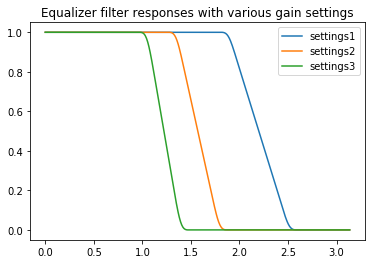

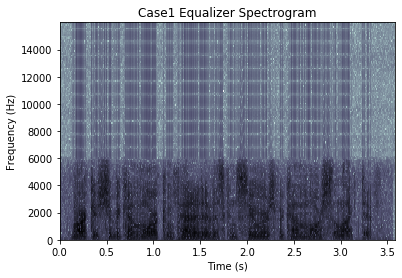

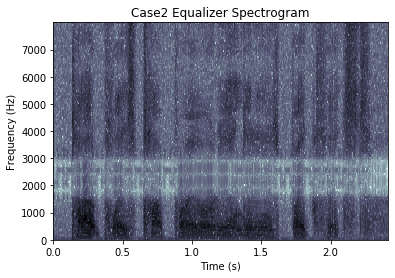

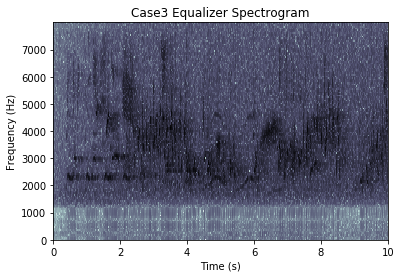

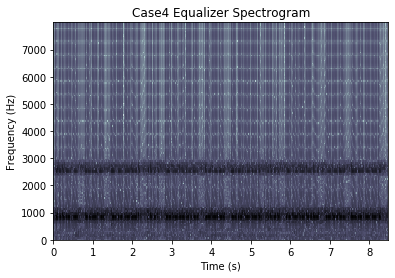

In [84]:
# Design an equalizer function
def equalizer(input_sound, input_sr, gains):
    # YOUR CODE HERE
    prefilter_stft = stft(case1_audio, dft_size, hop_size, zero_pad, window)
    max_freq = np.max(np.fft.fftfreq(input_sound.size, 1.0/input_sr))
    #freq=[0,100,200,400,800,1600,3200,max_freq/2] for six bands with center frequencies at 100Hz, 200Hz, 400Hz, 800Hz, 1600Hz and 3200Hz
    fir_filter = scipy.signal.firwin2(len(prefilter_stft[0]), freq=np.linspace(0,max_freq/2, len(gains)), gain=gains, fs=max_freq)
    return fir_filter

# Show its response with various gain settings
# YOUR CODE HERE

case1_eq_filter_1 = equalizer(case1_audio, case1_sr, [1,1,1,1,0.0001,0.0001]) #settings1
case1_eq_w_1, case1_eq_h_1 = scipy.signal.freqz(case1_eq_filter_1)
plt.plot(case1_eq_w_1, np.abs(case1_eq_h_1), label='settings1')
case1_eq_1 = scipy.signal.convolve(case1_eq_filter_1, case1_audio)
case1_eq_filter_2 = equalizer(case1_audio, case1_sr, [1,1,1,1,0.0001,0.0001,0.0001,0.0001]) #settings2
case1_eq_w_2, case1_eq_h_2 = scipy.signal.freqz(case1_eq_filter_2)
plt.plot(case1_eq_w_2, np.abs(case1_eq_h_2), label='settings2')
case1_eq_2 = scipy.signal.convolve(case1_eq_filter_2, case1_audio)
case1_eq_filter_3 = equalizer(case1_audio, case1_sr, [1,1,1,1,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001]) #settings3
case1_eq_w_3, case1_eq_h_3 = scipy.signal.freqz(case1_eq_filter_3)
plt.plot(case1_eq_w_3, np.abs(case1_eq_h_3), label='settings3')
case1_eq_3 = scipy.signal.convolve(case1_eq_filter_3, case1_audio)
plt.title("Equalizer filter responses with various gain settings")
plt.legend()

# Show how it can denoise the examples in part 1
# YOUR CODE HERE
#CASE 1
case1_eq_filter = equalizer(case1_audio, case1_sr, [1,1,1,1,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001])
case1_eq_audio = scipy.signal.convolve(case1_eq_filter, case1_audio)
case1_eq_stft = stft(case1_eq_audio, dft_size, hop_size, zero_pad, window)
plot_spec(case1_eq_audio, case1_sr, case1_eq_stft, dft_size, zero_pad, 'Case1 Equalizer')
sound(case1_eq_audio, rate=case1_sr, label='Case1 Equalizer')

#CASE 2
case2_eq_filter = equalizer(case2_audio, case2_sr, [1,1,1,1,0.0001,0.0001,0.0001,0.0001,0.0001,1,1,1,1,1,1,1,1,1,1,1,1,1])
case2_eq_audio = scipy.signal.convolve(case2_eq_filter, case2_audio)
case2_eq_stft = stft(case2_eq_audio, dft_size, hop_size, zero_pad, window)
plot_spec(case2_eq_audio, case2_sr, case2_eq_stft, dft_size, zero_pad, 'Case2 Equalizer')
sound(case2_eq_audio, rate=case2_sr, label='Case2 Equalizer')

#CASE 3
case3_eq_filter = equalizer(case3_audio, case3_sr, [0.0001,0.0001,1,1,1,1,1])
case3_eq_audio = scipy.signal.convolve(case3_eq_filter, case3_audio)
case3_eq_stft = stft(case3_eq_audio, dft_size, hop_size, zero_pad, window)
plot_spec(case3_eq_audio, case3_sr, case3_eq_stft, dft_size, zero_pad, 'Case3 Equalizer')
sound(case3_eq_audio, rate=case3_sr, label='Case3 Equalizer')

#CASE 4
case4_eq_filter = equalizer(case4_audio, case4_sr, [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,1,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,1,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001])
case4_eq_audio = scipy.signal.convolve(case4_eq_filter, case4_audio)
case4_eq_stft = stft(case4_eq_audio, dft_size, hop_size, zero_pad, window)
plot_spec(case4_eq_audio, case4_sr, case4_eq_stft, dft_size, zero_pad, 'Case4 Equalizer')
sound(case4_eq_audio, rate=case4_sr, label='Case4 Equalizer')